# Study of the Gold Purification Technological Process

This project aims to develop a machine learning model prototype for a company that specializes in providing solutions for the efficient operation of industrial enterprises. The model's primary objective is to predict the gold recovery coefficient from gold-bearing ore. The main challenge is to predict the gold recovery coefficient accurately. By forecasting this coefficient, the company can identify optimal operating conditions for its industrial clients, thus minimizing losses and enhancing overall productivity.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import optuna 

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import missingno as msno
from scipy.stats import randint

plt.style.use('ggplot')
pd.set_option('max_columns', 200)

In [36]:
gold_recovery_train = pd.read_csv('datasets/gold_industry_train.csv')
gold_recovery_test = pd.read_csv('datasets/gold_industry_test.csv')
gold_recovery_full = pd.read_csv('datasets/gold_industry_full.csv')

## Data Preparation

In [37]:
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

In [38]:
print('Training dataset:', gold_recovery_train.shape)
print('Test dataset:', gold_recovery_test.shape)
print('Original dataset:', gold_recovery_full.shape)

Training dataset: (14579, 87)
Test dataset: (4860, 53)
Original dataset: (19439, 87)


In [39]:
gold_recovery_full.sample(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
17087,2018-04-23 19:59:59,8.659367,9.104307,4.491220,37.021613,369.185626,48.318990,14.999605,4.599779,1000.369737,-300.238832,1299.765642,-399.935213,1297.022740,-399.803384,1194.861515,-400.810954,1100.075895,-400.528299,1000.167185,-400.135426,14.997581,4.600513,47185.978788,3963.608359,3963.583128,1.928066,19.482617,11.758064,8.921940,29.678390,84.257992,2.179304,6.159313,0.685469,14.443572,137.028373,12.986364,7.31,0.792136,1703.852117,-500.451985,1700.305411,-498.983094,1702.847053,-501.298749,1700.238123,-501.668618,33.586507,7.900427,11.716439,9.408993,3.468976,15.869510,3.495326,8.425640,25.095954,-500.706695,19.950488,-500.149524,24.978136,-500.173016,19.989232,-500.200333,17.954613,-500.922662,13.079135,-381.078496,17.982601,-500.706820,12.994044,-500.107856,14.958546,-500.463184,4.967480,16.838002,8.036194,4.917710,45.203249,4.169202,10.421360,9.115830,65.533475,3.413056,9.657939,3.905049,9.268258
4361,2016-08-17 22:59:59,11.147581,9.839268,4.128227,32.354704,359.555847,42.589613,12.994456,6.544185,855.334991,-300.527528,1359.246594,-399.733635

In [40]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


The data contains information about the gold ore enrichment process based on flotation. The dataset comprises a total of 87 columns and 19,439 rows. The columns provide information about the equipment status, feed and product parameters, gold, lead, silver, and solvent concentrations, as well as the gold recovery coefficient.

Most columns have non-null values, but some columns have missing values denoted as NaN. The data types of the columns are primarily float64, except for the date column, which is of type object.

### Formula for Enrichment Efficiency

$$Recovery = \frac{C\cdot(F-T)}{F\cdot(C-T)}\cdot100\% $$

Where:
- C is the concentration of gold in the final concentrate.
- F is the mass flow rate of gold in the feed.
- T is the mass flow rate of gold in the tailings.

In [41]:
C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']
T = gold_recovery_train['rougher.output.tail_au']
recovery = (C * (F-T))/(F*(C-T))*100

print(f'MAE: {mean_absolute_error(recovery, gold_recovery_train["rougher.output.recovery"])}')

MAE: 9.83758577644259e-15


**Conclusion**: The Mean Absolute Error (MAE) between the calculated enrichment efficiency using the formula and the corresponding feature values from the dataset is very small, indicating that the enrichment efficiency values in the dataset are highly accurate and reliable.

### Analysis of Features Unavailable in the Test Dataset

In [42]:
missing_cols = set(gold_recovery_train.columns) - set(gold_recovery_test.columns)
gold_recovery_train[missing_cols].dtypes

rougher.output.recovery                               float64
primary_cleaner.output.tail_ag                        float64
rougher.output.tail_au                                float64
secondary_cleaner.output.tail_au                      float64
primary_cleaner.output.concentrate_sol                float64
final.output.concentrate_sol                          float64
final.output.concentrate_pb                           float64
rougher.calculation.sulfate_to_au_concentrate         float64
final.output.tail_sol                                 float64
final.output.recovery                                 float64
secondary_cleaner.output.tail_pb                      float64
rougher.output.tail_pb                                float64
primary_cleaner.output.concentrate_pb                 float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
final.output.tail_au                                  float64
rougher.output.tail_sol                               float64
rougher.

All features have a data type of ***float***.

In the test dataset, the target features ```rougher.output.recovery``` and ```final.output.recovery``` are missing. To perform model validation, these target features should be added from the original dataset ```gold_recovery_full```.

The test dataset contains all the features that are known at the prediction time (the beginning of the process) and that can be used for training. Therefore, the remaining features from the train dataset should be removed, as they are not available in the test dataset.


### Data Preprocessing

Let's add the target features to the test dataset from the original dataset. To do this, we will use the key feature "date" to align the data.

In [43]:
# 1. Selecting the necessary columns from gold_recovery_full
targets = gold_recovery_full[['date', 'final.output.recovery', 'rougher.output.recovery']]

# 2. Merging the selected columns with gold_recovery_test based on the 'date' column
gold_recovery_test = gold_recovery_test.merge(targets, on='date', how='left')

Let's address the issue of missing data.

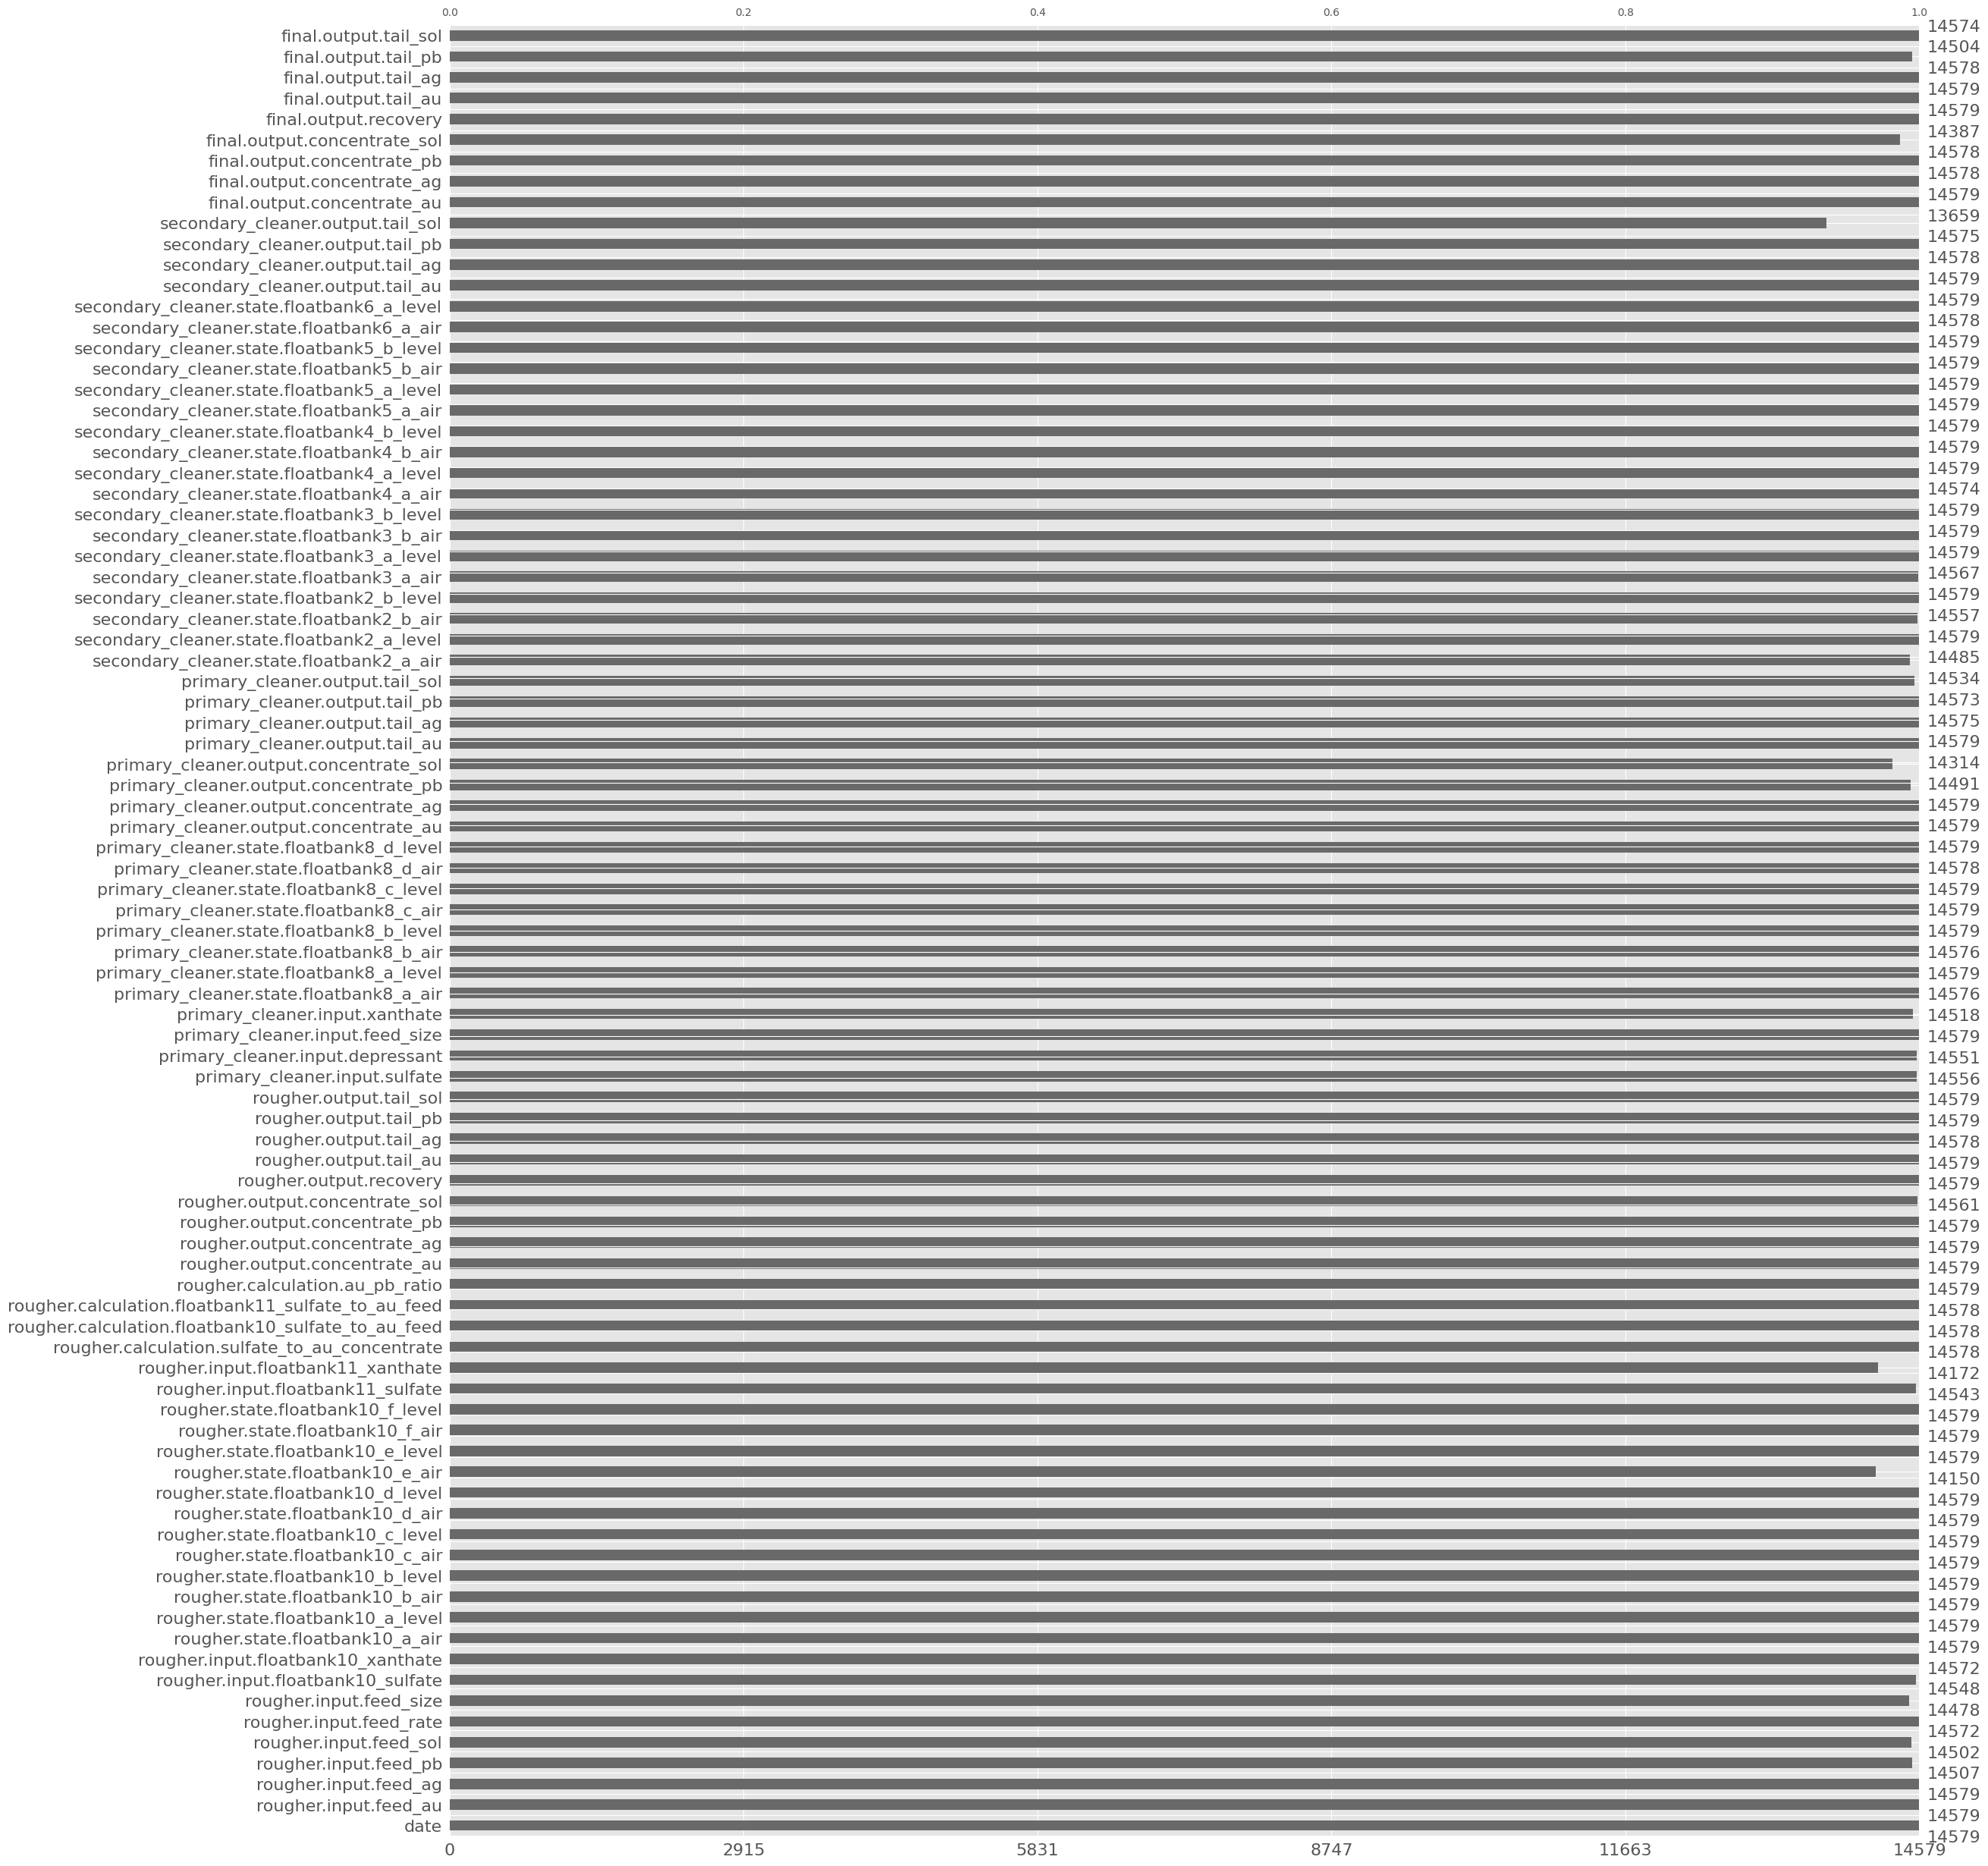

In [44]:
msno.bar(gold_recovery_train)
plt.show()

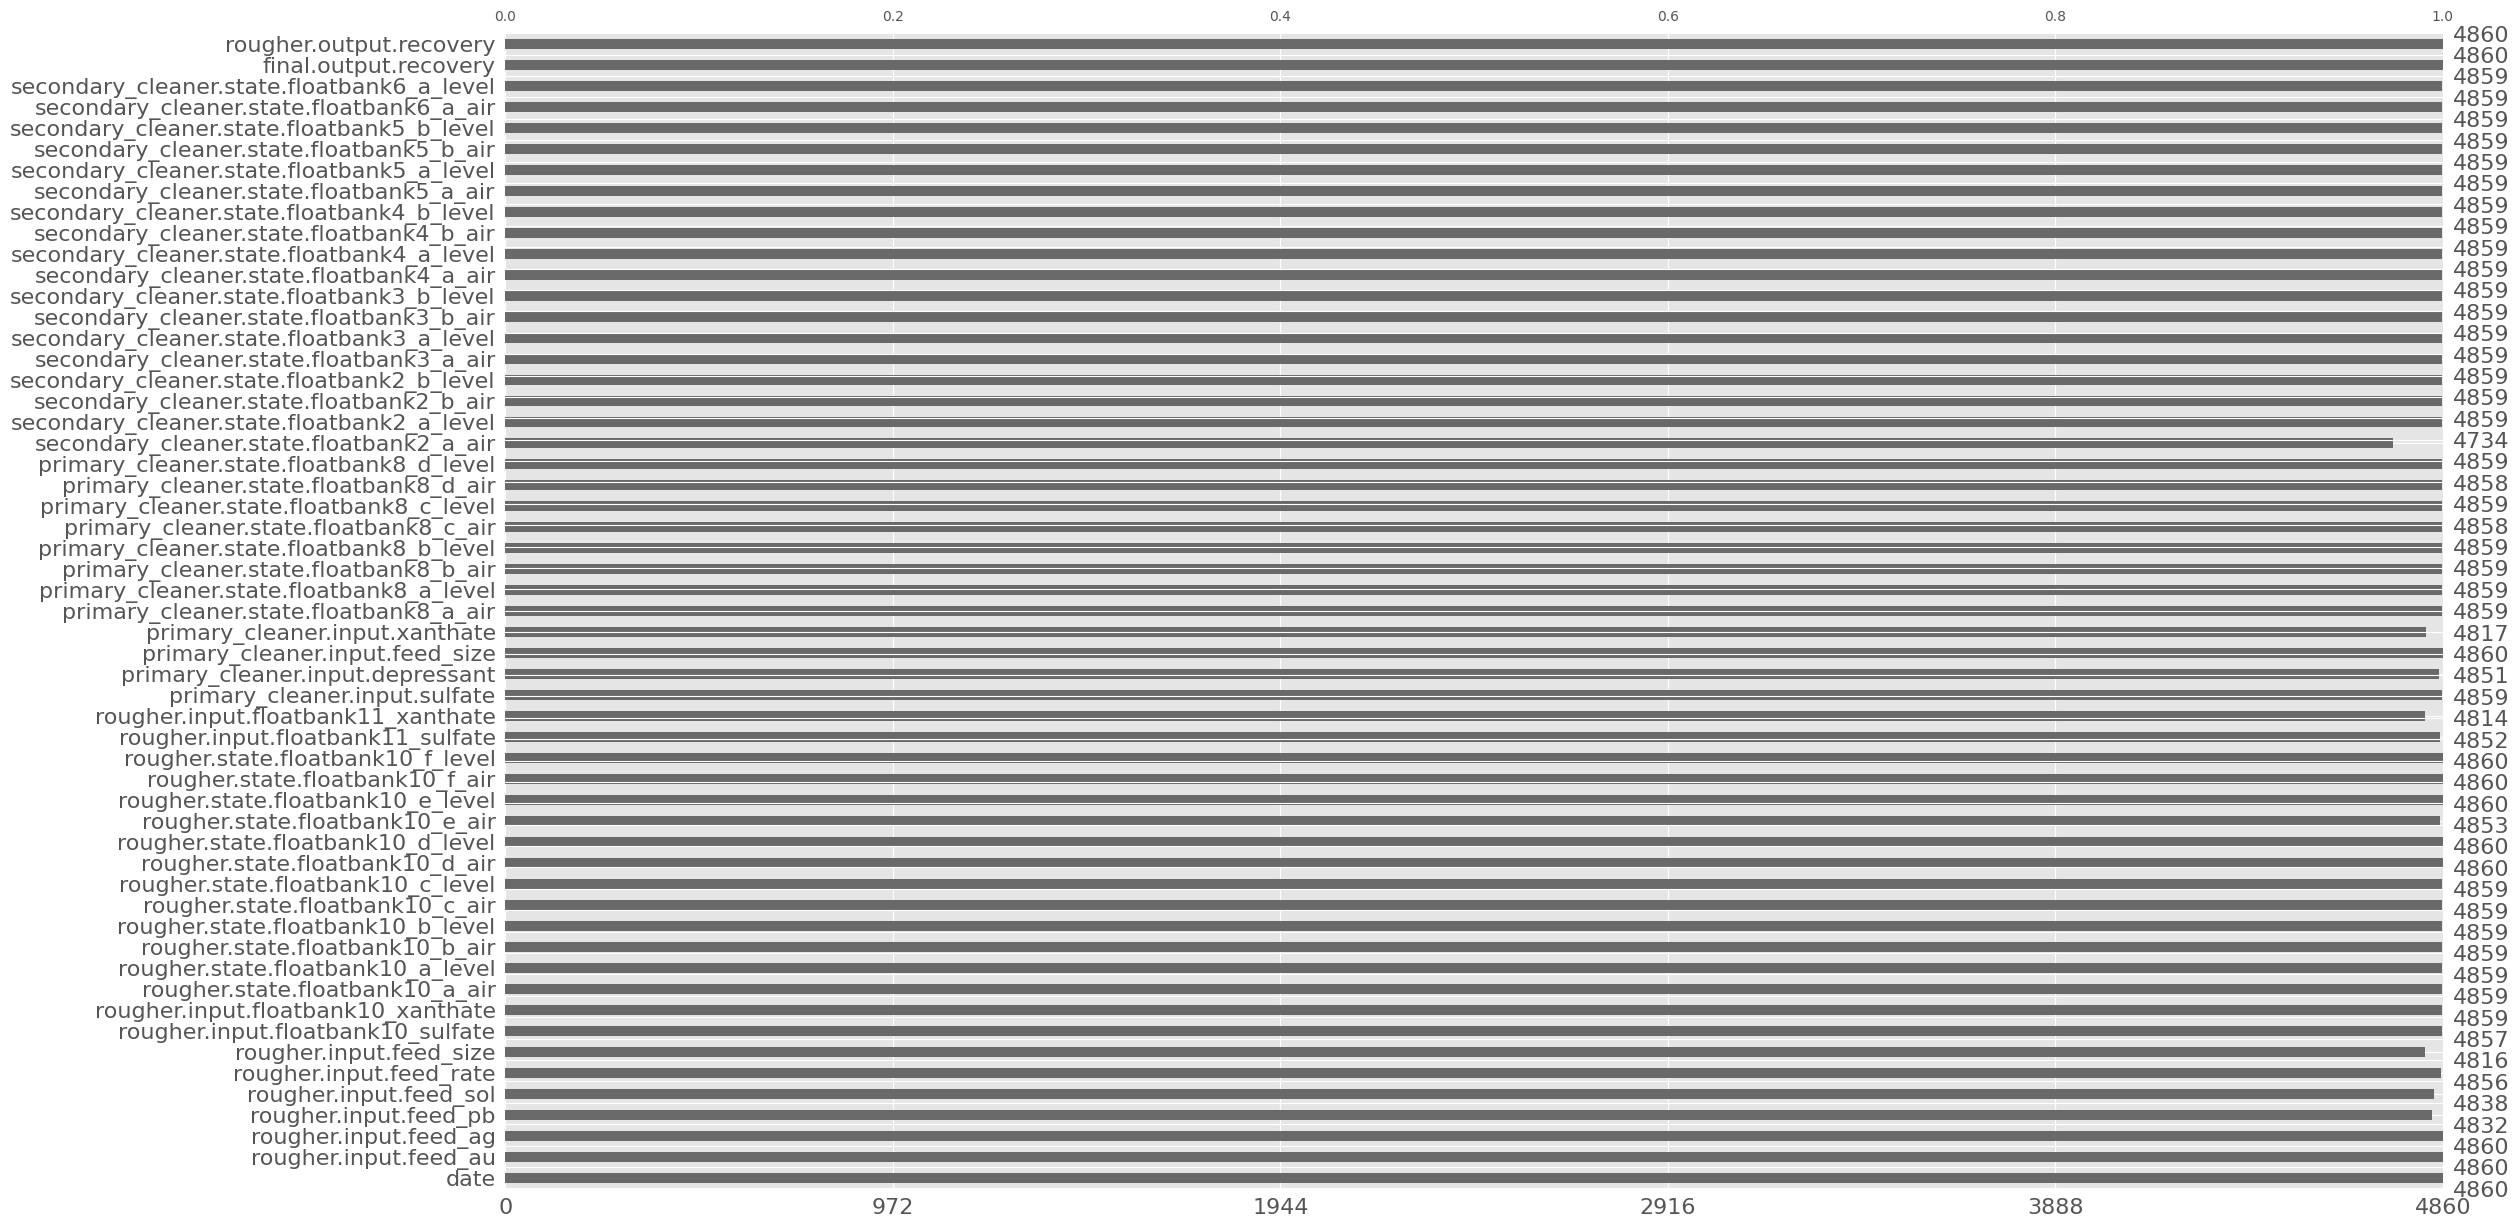

In [45]:
msno.bar(gold_recovery_test)
plt.show()

At first glance, we observe that the dataset contains some missing values, but their quantity is not significant. However, to ensure a more accurate analysis and build robust models, it is crucial to address these missing values.

We will employ the "forward fill" method to fill the gaps by utilizing the nearest available value since neighboring parameters in time are often similar. This approach takes advantage of the temporal similarity to impute missing values, resulting in a more complete dataset for analysis and modeling.

In [46]:
gold_recovery_train = gold_recovery_train.fillna(method='ffill')
gold_recovery_test = gold_recovery_test.fillna(method='ffill')

In [47]:
print('Missing Values:')
print('gold_recovery_train:', gold_recovery_train.isnull().values.any())
print('gold_recovery_test:', gold_recovery_test.isnull().values.any())

Missing Values:
gold_recovery_train: False
gold_recovery_test: False


## Data Analysis

###  Changes in Metal Concentrations (Au, Ag, Pb) at Various Cleaning Stages

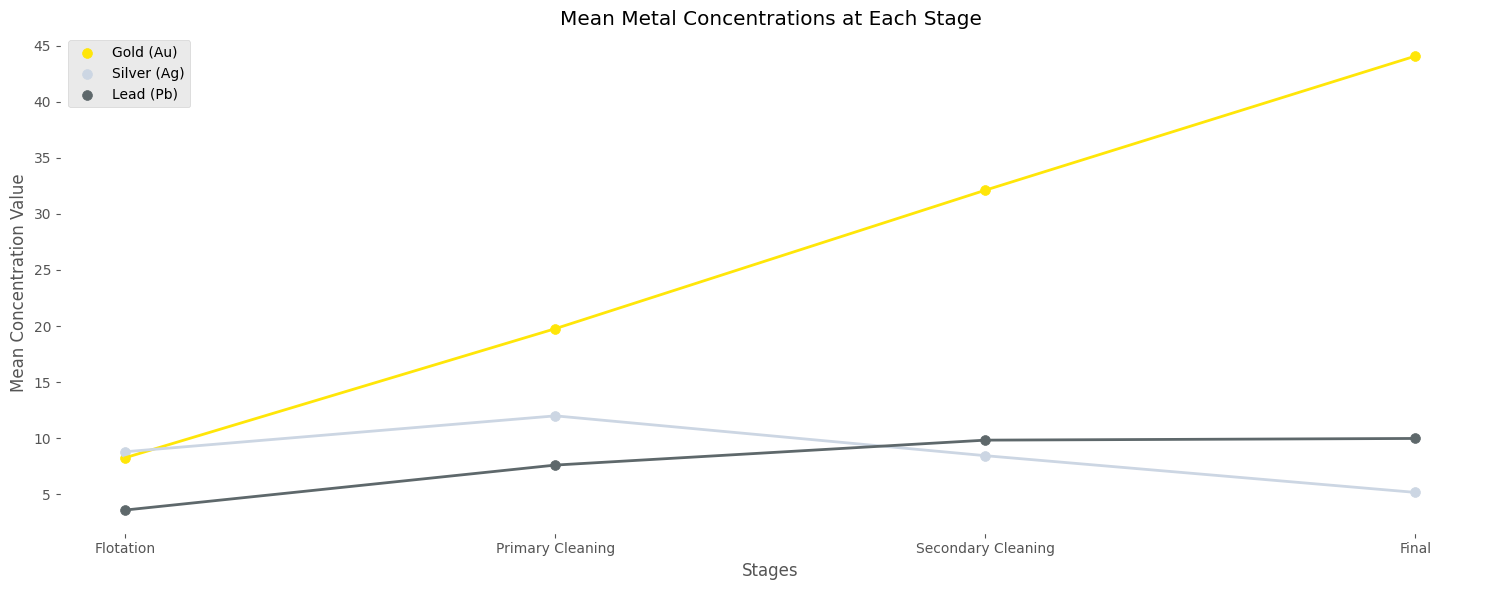

In [48]:
stages = ['rougher.input.feed_au',
          'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au',
          'final.output.concentrate_au']

# Calculate the mean concentration of each metal at each stage
mean_concentration = {
    'Gold (Au)': [gold_recovery_full[stage].mean() for stage in stages],
    'Silver (Ag)': [gold_recovery_full[stage.replace('au', 'ag')].mean() for stage in stages],
    'Lead (Pb)': [gold_recovery_full[stage.replace('au', 'pb')].mean() for stage in stages]
}

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_facecolor('white')

metal_colors = {
    'Gold (Au)': '#ffe608',
    'Silver (Ag)': '#ccd6e3',
    'Lead (Pb)': '#5e686b'
}

# Plot the scatter and line for each metal
for metal, color in metal_colors.items():
    ax.scatter(np.arange(len(stages)), mean_concentration[metal], color=color, label=metal, s=50)
    ax.plot(np.arange(len(stages)), mean_concentration[metal], color=color, lw=2)

ax.set_xlabel('Stages')
ax.set_ylabel('Mean Concentration Value')
ax.set_title('Mean Metal Concentrations at Each Stage')

ax.set_xticks(np.arange(len(stages)))
custom_labels = ['Flotation', 'Primary Cleaning', 'Secondary Cleaning', 'Final']
ax.set_xticklabels(custom_labels)

ax.legend()
plt.tight_layout()
plt.show()

- The concentration of Au (gold) significantly increases throughout all cleaning stages. In the end, the concentration of Au becomes approximately 5.3 times higher than at the initial stage.

- The concentration of Ag (silver) decreases starting from the flotation stage and continues to decrease in the subsequent stages.

- The concentration of Pb (lead) gradually increases throughout all cleaning stages. In the end, the concentration of Pb becomes approximately 2.7 times higher than at the initial stage.

Thus, we can draw conclusions about the nature of changes in the concentration of different metals at each cleaning stage. The concentration of Au increases, Ag decreases, and Pb gradually increases.

### Comparison of Feed Particle Size Distributions between Training and Test Datasets

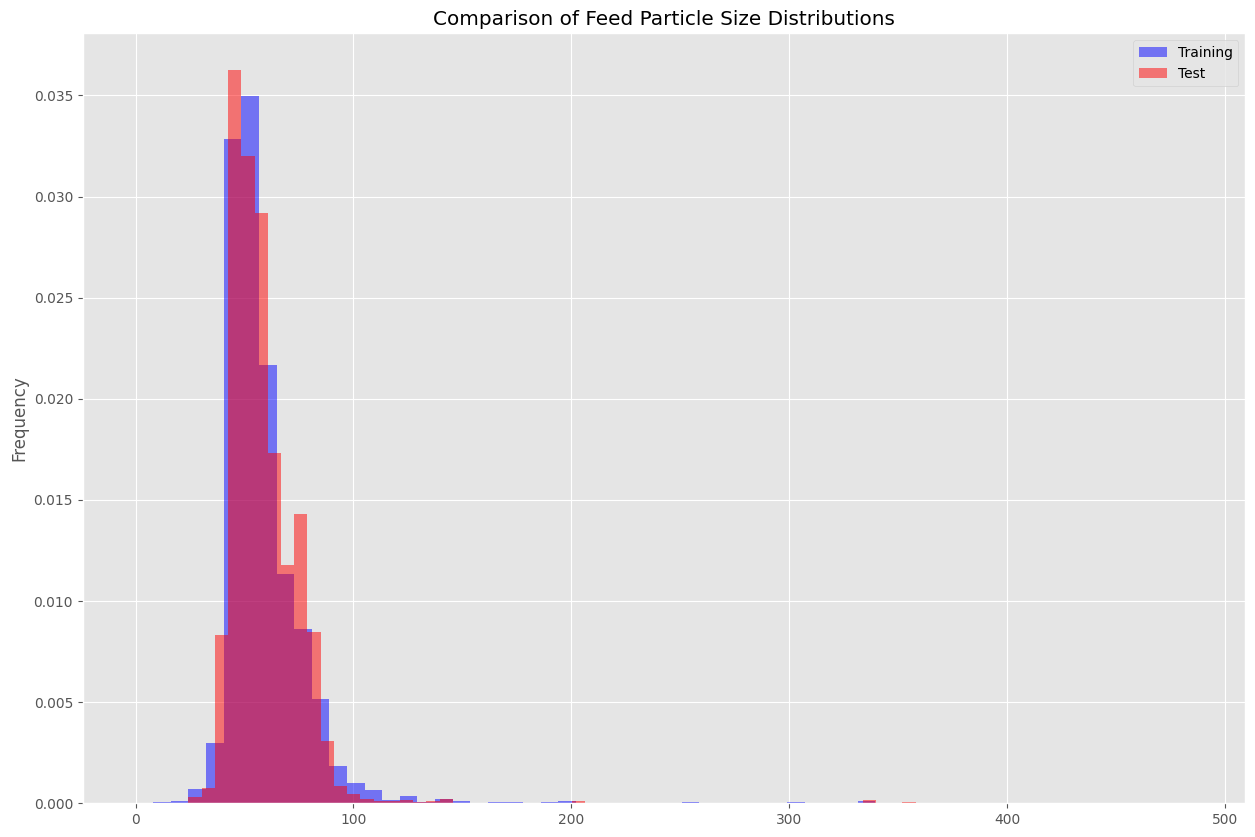

In [49]:
train_particle_size = gold_recovery_train['rougher.input.feed_size']
test_particle_size = gold_recovery_test['rougher.input.feed_size']

plt.figure(figsize=(15, 10))
plt.hist(train_particle_size, bins=60, alpha=0.5, color='blue', label='Training', density=True)
plt.hist(test_particle_size, bins=60, alpha=0.5, color='red', label='Test', density=True)

plt.ylabel('Frequency')
plt.title('Comparison of Feed Particle Size Distributions')
plt.legend()

plt.show()

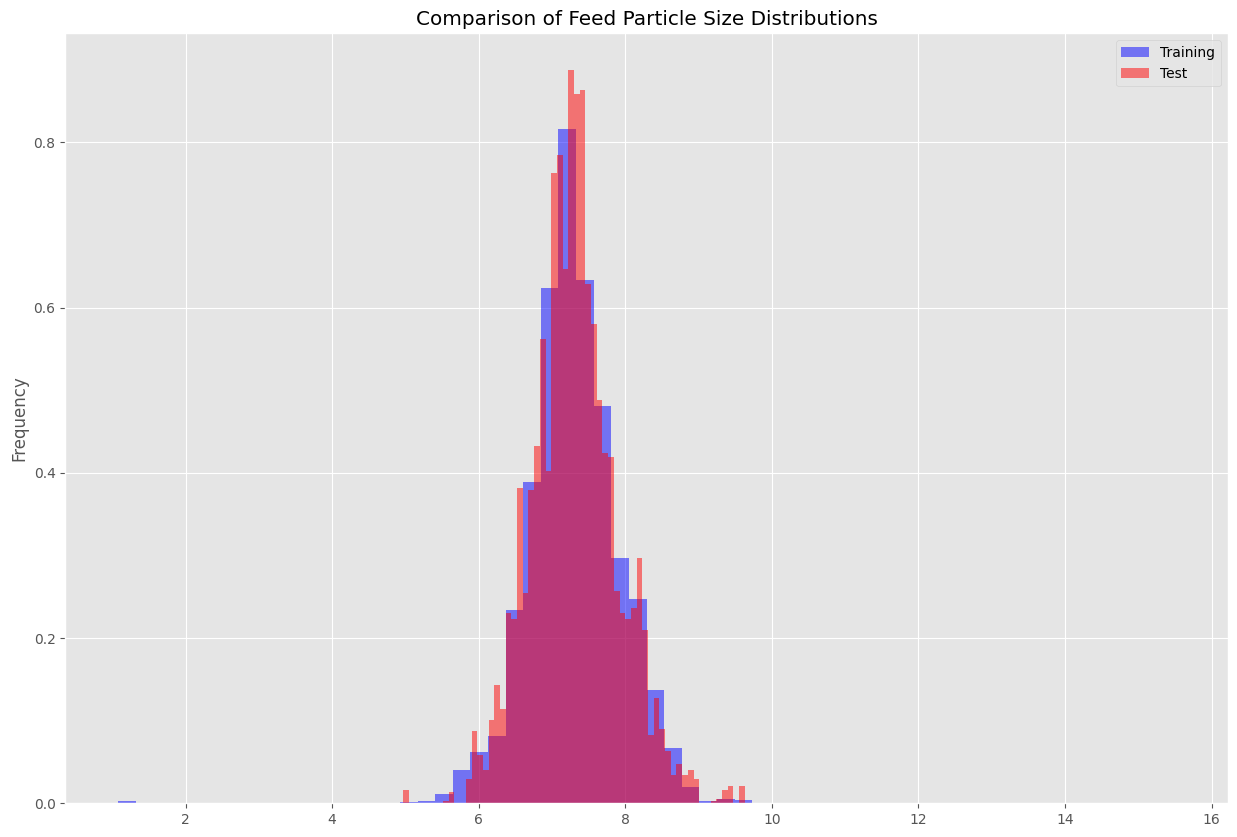

In [50]:
train_particle_size = gold_recovery_train['primary_cleaner.input.feed_size']
test_particle_size = gold_recovery_test['primary_cleaner.input.feed_size']

plt.figure(figsize=(15, 10))
plt.hist(train_particle_size, bins=60, alpha=0.5, color='blue', label='Training', density=True)
plt.hist(test_particle_size, bins=60, alpha=0.5, color='red', label='Test', density=True)

plt.ylabel('Frequency')
plt.title('Comparison of Feed Particle Size Distributions')
plt.legend()

plt.show()

Based on the comparative analysis of the feed particle size distribution graphs in the training and test datasets, we can conclude that these distributions are similar. This indicates the similarity of data between the training and test datasets. We can assume that a model trained on the training dataset will have the ability to accurately predict results on the test dataset.

### Analysis of the Total Concentration of All Substances at Different Stages: In the Feed, Rougher, and Final Concentrates

For further analysis, let's calculate the sum of all substances (metals + sol) at each stage and add these values to the gold_recovery_train dataset. This will allow us to identify potential anomalies in the data. However, in the context of our task, there is no need to remove anomalies from the test dataset, as they cannot negatively impact the model's performance. In the worst case, the model will simply provide inaccurate predictions for such anomalous values.

To ensure data purity, let's remove anomalous values from the training dataset. This will help us avoid distortions and improve the model's training quality.

Before Anomaly Removal


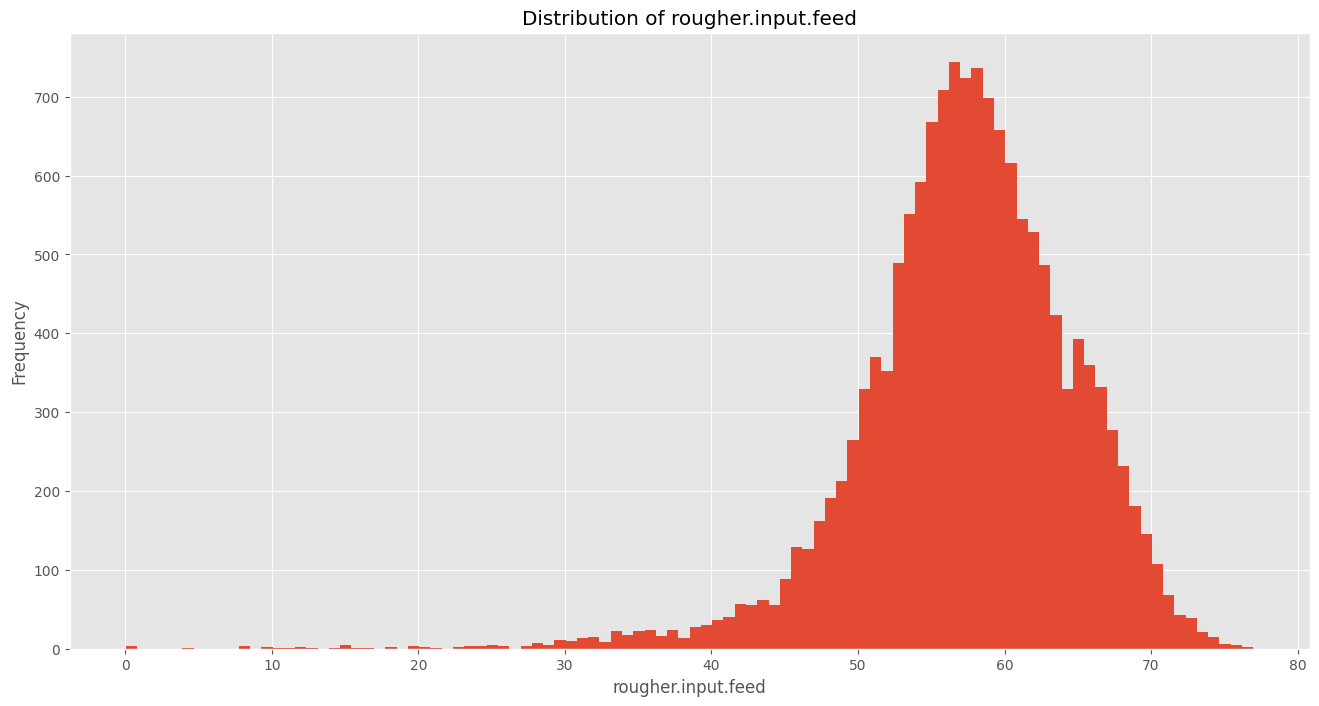

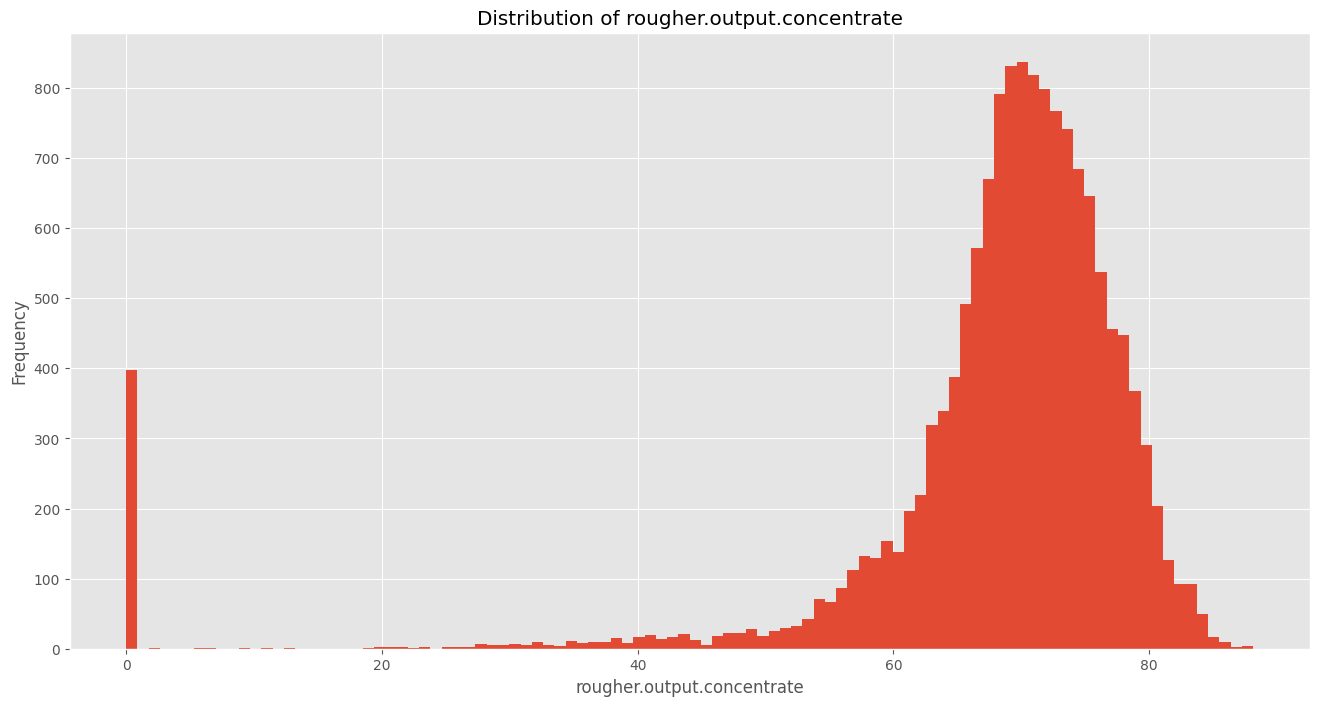

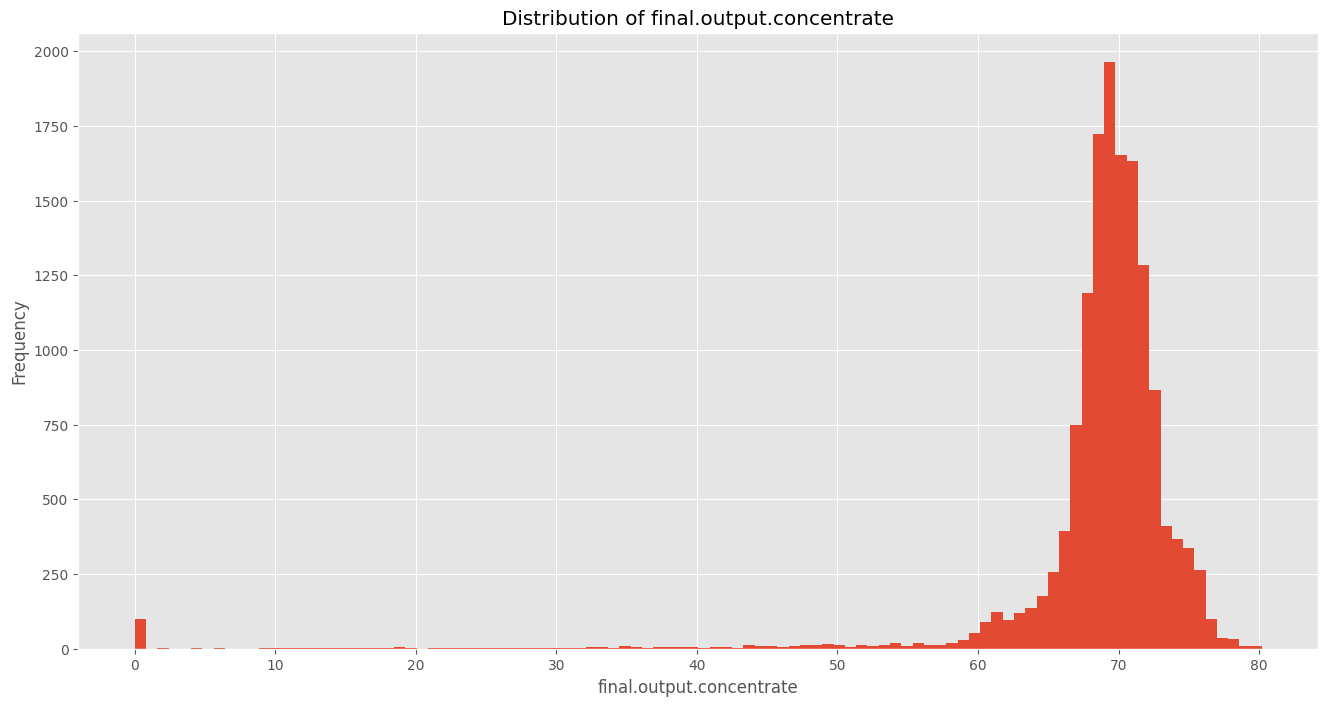


After Anomaly Removal


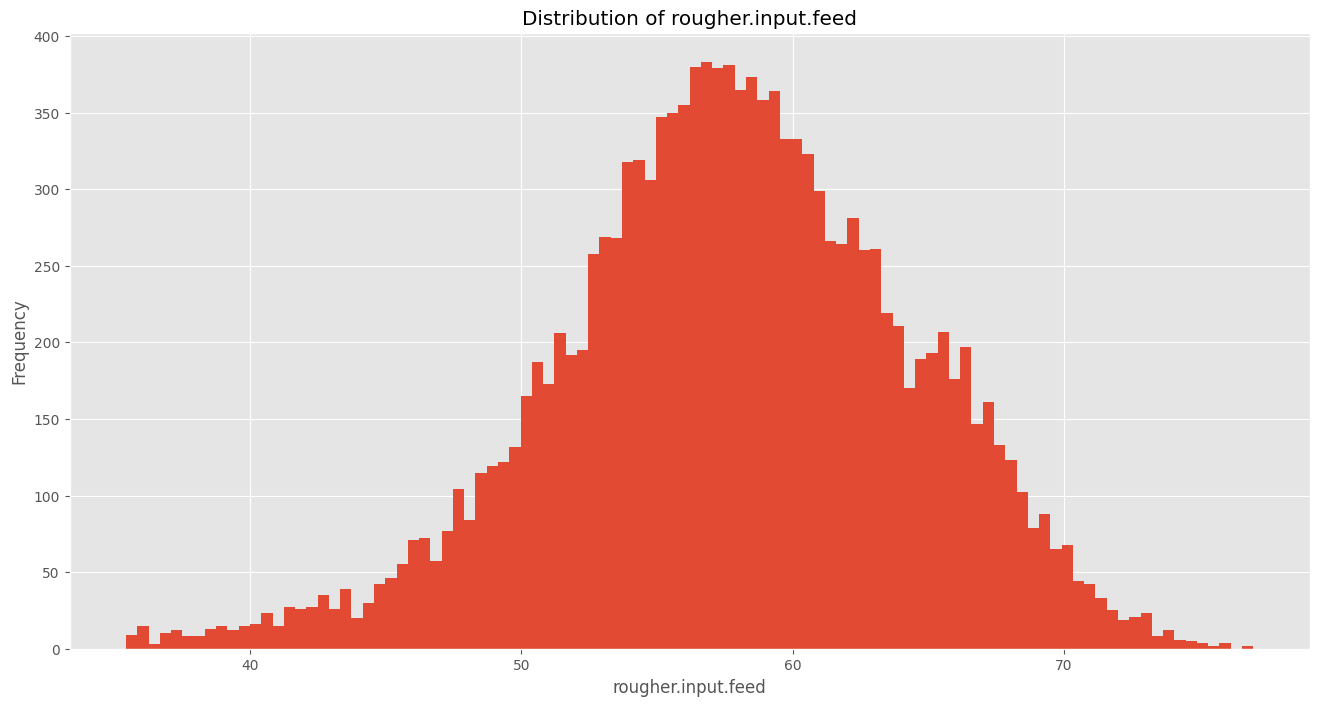

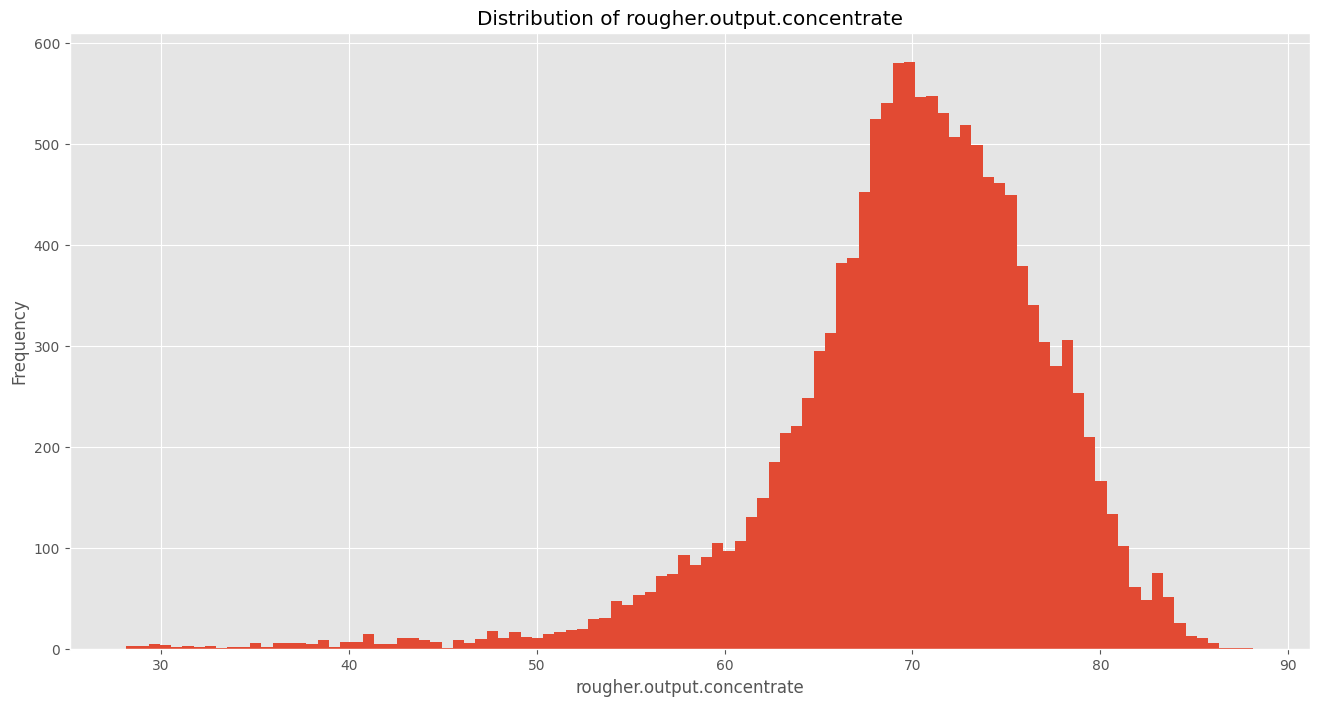

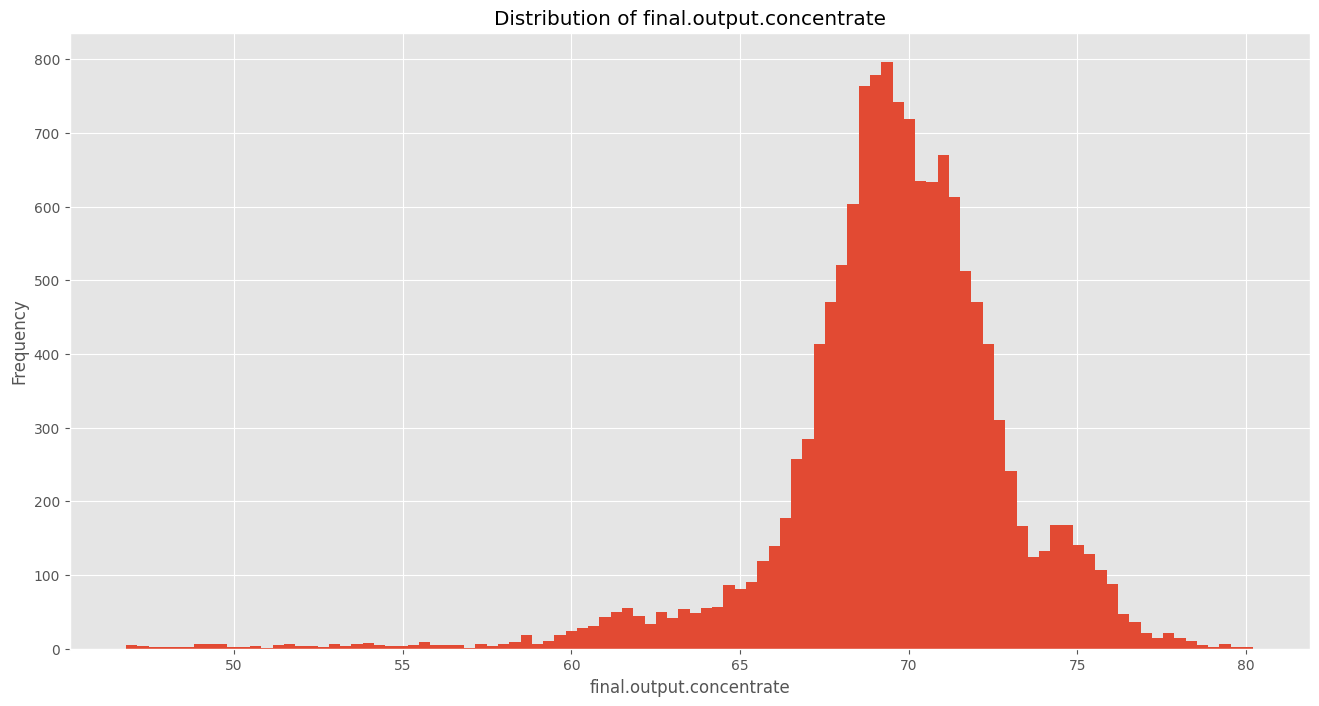

In [51]:
def calculate_and_plot_sum_concentrations(dataframe, concentrate_metrics):
    for metric in concentrate_metrics:
        dataframe[metric] = 0
        for substance in ['au', 'ag', 'pb', 'sol']:
            dataframe[metric] += dataframe[f'{metric}_{substance}']
    
    for column in concentrate_metrics:
        plt.figure(figsize=(16, 8))
        dataframe[column].hist(bins=100)
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

# Define the concentrate metrics
concentrate_metrics = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'final.output.concentrate'
]

print("Before Anomaly Removal")
calculate_and_plot_sum_concentrations(gold_recovery_train, concentrate_metrics)

# remove anomalous values from the training dataset
for column in concentrate_metrics:
    threshold = 3 * gold_recovery_train[column].std()
    gold_recovery_train = gold_recovery_train[~(np.abs(gold_recovery_train[column] - gold_recovery_train[column].mean()) > threshold)]

print("\nAfter Anomaly Removal")
calculate_and_plot_sum_concentrations(gold_recovery_train, concentrate_metrics)


## Model

Let's keep only those columns in the gold_recovery_train dataset that are present in the gold_recovery_test dataset. This will ensure that we train the model on consistent data and avoid errors due to feature mismatch. To do this, we will create a list of columns that exist in the test dataset and filter the train dataset based on this list.

In [52]:
columns_to_keep = gold_recovery_test.columns.intersection(gold_recovery_train.columns)
gold_recovery_train = gold_recovery_train[columns_to_keep]

### Function for Calculating the Final sMAPE

In [53]:
def calculate_smape(y_true, y_pred):
    epsilon = 1e-10  # Constant to avoid division by zero
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / (denominator + epsilon)) * 100
    return smape

def calculate_final_smape(y_true, y_pred):
    y_true_rougher = y_true['rougher.output.recovery']
    y_true_final = y_true['final.output.recovery']

    y_pred_rougher = y_pred[:, 0]
    y_pred_final = y_pred[:, 1]

    smape_rougher = calculate_smape(y_true_rougher, y_pred_rougher)
    smape_final = calculate_smape(y_true_final, y_pred_final)

    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape


In [54]:
smape_score = make_scorer(calculate_final_smape, greater_is_better=False)

### Selecting Relevant Attributes

At this stage, we are selecting attributes to build the regression model. We use a method to identify the key attributes that have a strong correlation with the target variables (`'rougher.output.recovery'` and `'final.output.recovery'`). To do this, we construct a correlation matrix and select the top 10 variables that are most correlated with the target features.

In [55]:
correlation = gold_recovery_train.corr(method='pearson')
columns = correlation.nlargest(10, TARGETS).index
columns

Index(['rougher.output.recovery', 'final.output.recovery',
       'primary_cleaner.input.sulfate', 'rougher.input.feed_au',
       'rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.state.floatbank10_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'rougher.input.floatbank10_xanthate', 'rougher.input.feed_sol'],
      dtype='object')

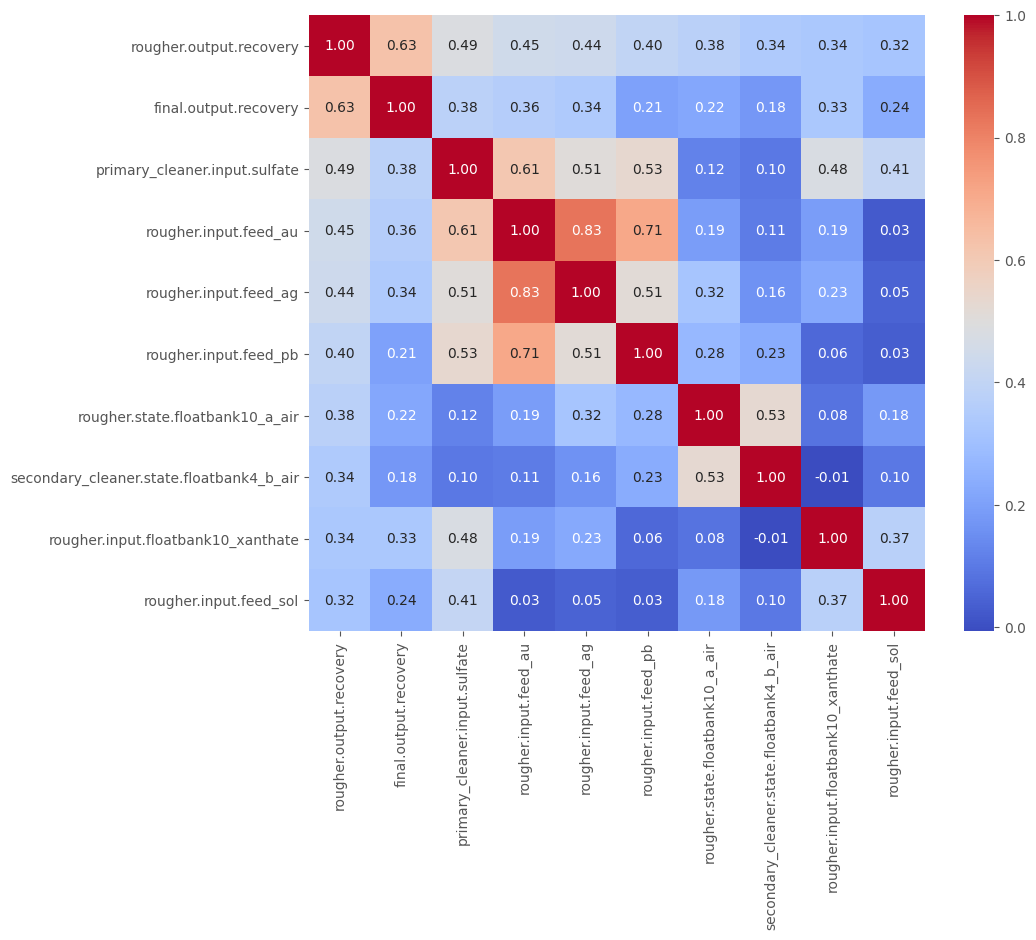

In [56]:
correlation_map = np.corrcoef(gold_recovery_train[columns].values.T)

# Create a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, 
                      cmap='coolwarm',
                      fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

### Model Training

During this phase, we will identify the features and target variables required for modeling the `rougher.output.recovery` and `final.output.recovery`.

In [57]:
X_train = gold_recovery_train[columns].drop(TARGETS, axis='columns')
y_train = gold_recovery_train[TARGETS]
X_test = gold_recovery_test[columns].drop(TARGETS, axis='columns')
y_test = gold_recovery_test[TARGETS]

In this step, we will train different models and assess their quality using the sMAPE metric. Subsequently, we will choose the model that achieves the most favorable sMAPE value among all the models evaluated.

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(random_state=42), {'max_depth': randint(2, 20)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': randint(10, 51),
        'max_depth': randint(1, 10),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 6)
    }),
    'Ridge Regression': (Ridge(random_state=42), {'alpha': uniform(loc=0, scale=1)}),
    'Lasso Regression': (Lasso(random_state=42), {'alpha': uniform(loc=0, scale=1)})
}

def train_and_tune_model(model, params, X_train, y_train, scoring):
    search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, scoring=scoring)
    search.fit(X_train, y_train)
    best_score = -search.best_score_
    best_params = search.best_params_
    return best_score, best_params


best_model_name = None
best_model = None
best_smape = float('inf')
best_params = None

for model_name, (model, params) in models.items():
    current_smape, best_params = train_and_tune_model(model, params, X_train, y_train, smape_score)
    print(f"{model_name} - Best sMAPE: {current_smape:.4f}")
    print(f"{model_name} - Best parameters: {best_params}")
    print()
    
    if current_smape < best_smape:
        best_smape = current_smape
        best_model_name = model_name
        best_model = model
        best_params = best_params

/Users/mars/opt/anaconda3/envs/da_practicum/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear Regression - Best sMAPE: 7.8011
Linear Regression - Best parameters: {}

Decision Tree - Best sMAPE: 8.1769
Decision Tree - Best parameters: {'max_depth': 4}

Random Forest - Best sMAPE: 7.9127
Random Forest - Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}

Ridge Regression - Best sMAPE: 7.8010
Ridge Regression - Best parameters: {'alpha': 0.9281146171432064}

Lasso Regression - Best sMAPE: 7.7355
Lasso Regression - Best parameters: {'alpha': 0.23629542227025024}



In [80]:
print(best_params)

{'alpha': 0.23629542227025024}


###  the best model 

In [81]:
print(best_model_name)
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)

print(calculate_final_smape(y_test, preds))

Lasso Regression
7.433577977220136


## Conclusion

After training and evaluating various regression models using the sMAPE metric, we found that the Lasso Regression model outperformed the other models, including Linear Regression, Decision Tree, Random Forest, and Ridge Regression. The Lasso Regression model achieved the lowest sMAPE value, indicating its superior ability to make accurate predictions on the test dataset.

Overall, the choice of the Lasso Regression model as the best performer suggests that the regularization and feature selection techniques employed by the model are well-suited for this specific prediction task. Therefore, we recommend using the Lasso Regression model for predicting the gold recovery efficiency from gold-bearing ore. However, further analysis and fine-tuning may be necessary to optimize the model's performance for specific industrial applications.